In [1]:
import numpy as np
import tensorflow as tf
import keras
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
import time
import warnings
import lime
from keras.applications.inception_v3 import decode_predictions
from sklearn.linear_model import LinearRegression
from lime import lime_image
from matplotlib import pyplot as plt
from skimage.segmentation import mark_boundaries
print('Notebook running: tensorflow ', tf.__version__)
print('Notebook running: keras ', keras.__version__)
np.random.seed(0)

Using TensorFlow backend.
Notebook running: tensorflow  2.4.1
Notebook running: keras  2.3.1


In [2]:
model = tf.keras.applications.inception_v3.InceptionV3()  #Load pretrained model # 299x299

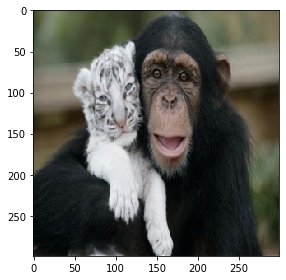

In [3]:
img = skimage.io.imread('immagine.jpg')
img = skimage.transform.resize(img, (299,299))
skimage.io.imshow(img)

In [4]:
preds = model.predict(img[np.newaxis,:,:,:])
decode_predictions(preds,top=10)[0] #Top 5 classes

[('n02481823', 'chimpanzee', 0.86702746),
 ('n02480855', 'gorilla', 0.005830233),
 ('n02484975', 'guenon', 0.0036718692),
 ('n02483708', 'siamang', 0.0032601582),
 ('n02480495', 'orangutan', 0.0027755739),
 ('n02486261', 'patas', 0.0018741352),
 ('n02488702', 'colobus', 0.001084156),
 ('n02487347', 'macaque', 0.0008899289),
 ('n02128757', 'snow_leopard', 0.00085683225),
 ('n02483362', 'gibbon', 0.0008204315)]

In [5]:
preds_classes = np.argmax(preds, axis=-1)
print('ImageNet index =',preds_classes)

ImageNet index = [367]


In [6]:
superpixels = skimage.segmentation.quickshift(img, kernel_size=4,max_dist=10, ratio=0.01)
num_superpixels = np.unique(superpixels).shape[0]
print(num_superpixels)


77


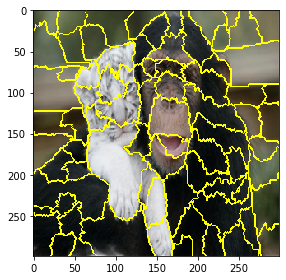

In [7]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(img, superpixels)) # show segmented image

In [8]:
num_perturb = 0
perturbations = 0

In [9]:
explainer = lime_image.LimeImageExplainer()

In [10]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels

explanation = explainer.explain_instance(img.astype('double'), model,top_labels=20, hide_color=None, num_samples=800)

100%|██████████| 800/800 [01:41<00:00,  7.87it/s]


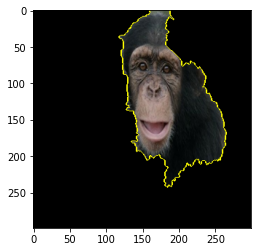

In [11]:
#why chimpanzee?
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

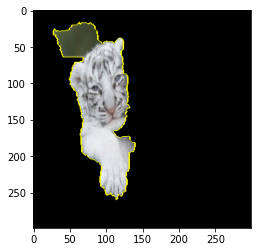

In [12]:
#why snow leopard?
temp, mask = explanation.get_image_and_mask(explanation.top_labels[8], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

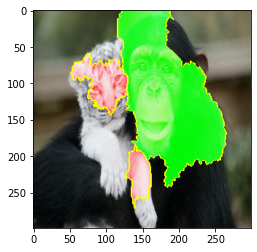

In [13]:
#how much +chimpanzee -tiger
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False,min_weight=0.04)
plt.imshow(mark_boundaries(temp, mask))

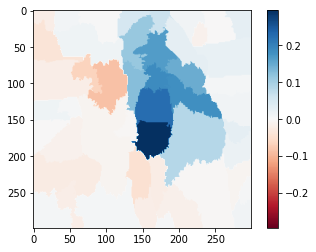

In [14]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()